In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Activation, RepeatVector, TimeDistributed
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import math

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.switch_backend('TkAgg')
%matplotlib inline

# get data
fname = "./datos.csv"
data = pd.read_csv(fname, index_col=0)
data.index = data.index.astype("datetime64[ns]")
data.sort_index(ascending=True, inplace=True)
data_fixed = data.groupby(lambda x: x.weekofyear).transform(lambda x: x.fillna(x.mean()))
all_levels = data_fixed.iloc[:, :6].values.astype("float64")
names = data_fixed.columns[:6]
river_i_list = [0,1,2,3,4,5]
river_i_list = [5]

np.random.seed(7)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def train_test_split(dataset, train_frac):
    train_size = int(len(dataset)*train_frac)
    return dataset[:train_size, :], dataset[train_size: ,:]

def create_datasets(dataset, look_back=1, look_ahead=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-look_ahead+1):
        window = dataset[i:(i+look_back), 0]
        data_x.append(window)
        data_y.append(dataset[i + look_back:i + look_back + look_ahead , 0])
    return np.array(data_x), np.array(data_y)

def reverse_scale(data, mean, std):
    for x in np.nditer(data, op_flags=['readwrite']):
        x[...] = x*std + mean
    return data

def calculate_error(train_y, test_y, pred_train, pred_test):
    test_score = math.sqrt(mean_squared_error(test_y, pred_test))
    train_score = math.sqrt(mean_squared_error(train_y, pred_train))
    return train_score, test_score

def mean_absolute_percentage(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

def root_mse(pred_test, test_y):
    t = []
    for i in range(20):
        score = math.sqrt(mean_squared_error(pred_test[:,i,:], test_y[:,i,:]))
        t.append(score)
        print(i+1, "  ->  ", score)
        
    return score

def plot_errors(pred_test, test_y, errors):
    plt.figure(figsize=(20,10))
    plt.subplot(311)
    plt.plot(test_y[:,23,:], label="Observed")
    plt.plot(pred_test[:,23,:], color="red", label="Predicted, MAPE: "+ str(round(errors[23], 5))+"%")
    plt.title("24 step ahead prediction")
    plt.ylabel("River Level")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    
    plt.subplot(312)
    plt.plot(pred_test[:,47,:], color="red", label="Predicted, MAPE: "+ str(round(errors[47], 5))+"%")
    plt.plot(test_y[:,47,:], label="Observed")
    plt.title("48 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)

    plt.subplot(313)
    plt.plot(pred_test[:,71,:], color="red", label="Predicted, MAPE: "+ str(round(errors[71], 5))+"%")
    plt.plot(test_y[:,71,:], label="Observed")
    plt.title("72 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    plt.tight_layout()
    plt.show()

def build_seq2seq_model(look_ahead=1):
    m = Sequential()
    
    # encoder
    m.add(GRU(16, input_shape=(None, 1)))
    # m.add(GRU(16, input_dim = 1))
    
    # repeat for the number of steps out
    m.add(RepeatVector(look_ahead))
    
    # decoder
    m.add(GRU(8, return_sequences=True))
    m.add(GRU(8, return_sequences=True))
    
    # split the output into timesteps
    m.add(TimeDistributed(Dense(1)))
    
    m.compile(loss='mse', optimizer='rmsprop')
    
    m.summary()
    return m


In [34]:
scores = []
history = []
model_list = []
river_i_list = [5]
look_back = 24*5
look_ahead = 72+1
split = 0.8
epochs = 1
batch_size = 800
model = build_seq2seq_model(look_ahead)
river=all_levels[:, 5]  # zgz

# normalize
river_mean, river_std = river.mean(), river.std()
river = preprocessing.scale(river).reshape(len(river), 1)

# split data into train and test subsets
train, test = train_test_split(river, split)
train_x, train_y = create_datasets(train, look_back, look_ahead)
test_x, test_y = create_datasets(test, look_back, look_ahead)

# reshape the data to match Keras LSTM gate input [samples, time steps, features]
train_x = train_x[:, :, None]
train_y = train_y[:, :, None]

test_x = test_x[:, :, None]
test_y = test_y[:, :, None]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 16)                864       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 73, 16)            0         
_________________________________________________________________
gru_8 (GRU)                  (None, 73, 8)             600       
_________________________________________________________________
gru_9 (GRU)                  (None, 73, 8)             408       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 73, 1)             9         
Total params: 1,881
Trainable params: 1,881
Non-trainable params: 0
_________________________________________________________________


In [50]:
# features 
feat0 = all_levels[:, 0]
feat0 = preprocessing.scale(feat0)[:, None]
feat0_train, feat0_test = train_test_split(feat0, split)

feat0_train_x, feat0_train_y = create_datasets(feat0_train, look_back, look_ahead)
feat0_test_x, feat0_test_y = create_datasets(feat0_test, look_back, look_ahead)

train_x_feat = np.stack((train_x, feat0_train_x[:, :, None]), axis=2).squeeze()
train_y_feat = np.stack((train_y, feat0_train_y[:, :, None]), axis=2).squeeze()


test_x_feat = np.stack((test_x, feat0_test_x[:, :, None]), axis=2).squeeze()
test_y_feat = np.stack((test_y, feat0_test_y[:, :, None]), axis=2).squeeze()

In [53]:
m = Sequential()
m.add(GRU(16, input_shape=(None, 2)))
m.add(RepeatVector(look_ahead))
m.add(GRU(8, return_sequences=True))
m.add(GRU(8, return_sequences=True))
m.add(TimeDistributed(Dense(2)))
m.compile(loss='mse', optimizer='rmsprop')
m.summary()
model2 = m

history = model2.fit(
    x=train_x_feat, 
    y=train_y_feat, 
    epochs=20, 
    batch_size=batch_size, 
    verbose=2,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=2, mode='auto')]
)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_19 (GRU)                 (None, 16)                912       
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 73, 16)            0         
_________________________________________________________________
gru_20 (GRU)                 (None, 73, 8)             600       
_________________________________________________________________
gru_21 (GRU)                 (None, 73, 8)             408       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 73, 2)             18        
Total params: 1,938
Trainable params: 1,938
Non-trainable params: 0
_________________________________________________________________
Train on 61193 samples, validate on 15299 samples
Epoch 1/20
 - 114s - loss: 0.7727 - val_loss: 0.4586
Epoch 2/20
 - 104s - loss: 0.2037 - v

In [54]:
pred_train2 = model2.predict(train_x_feat)
pred_test2 = model2.predict(test_x_feat)

pred_train2 = reverse_scale(pred_train, river_mean, river_std)
pred_test2 = reverse_scale(pred_test, river_mean, river_std)

test_y2 = reverse_scale(test_y, river_mean, river_std)
train_y2 = reverse_scale(train_y, river_mean, river_std)

errors2 = [mean_absolute_percentage(test_y2[:,i,:], pred_test2[:,i,:]) for i in range(test_y2.shape[1])]

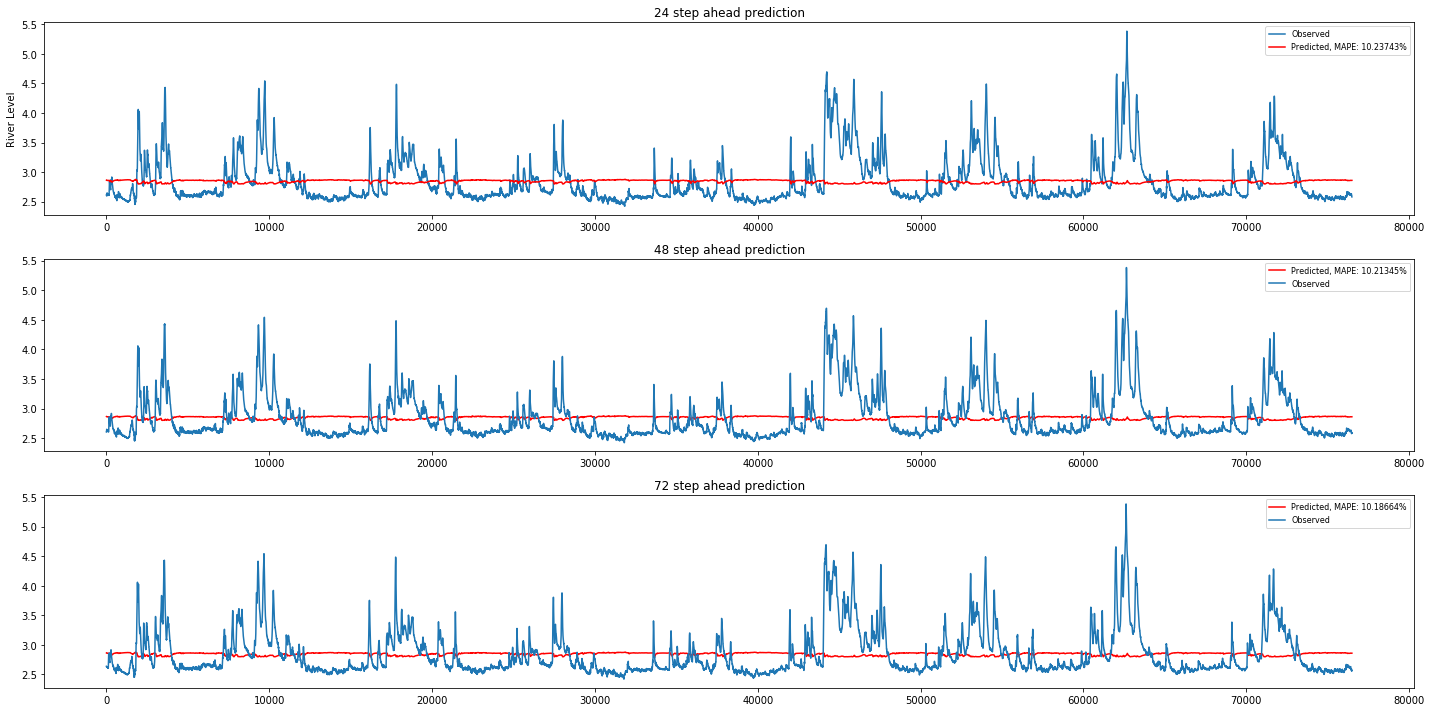

In [60]:
plot_errors(pred_train2, train_y2, errors2)

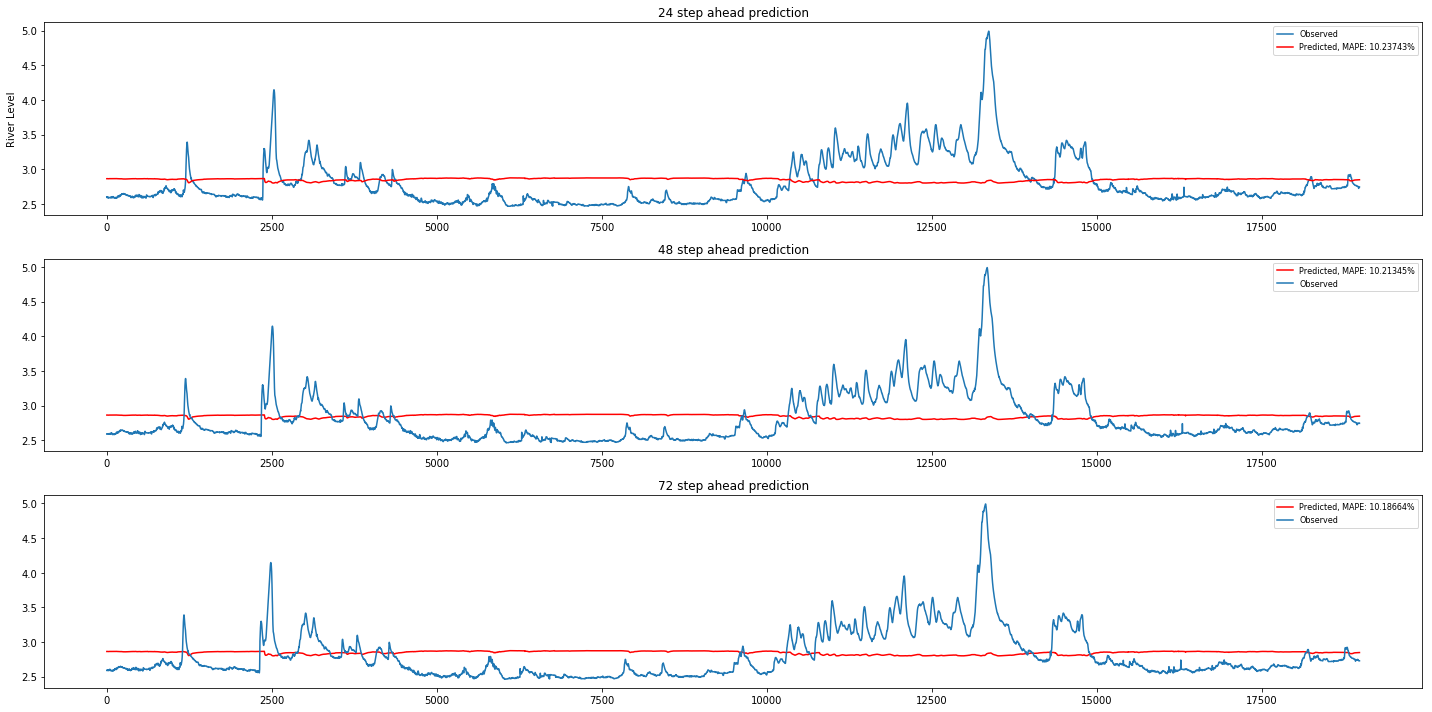

In [55]:
plot_errors(pred_test2, test_y2, errors2)

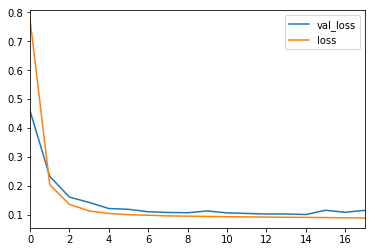

In [59]:
pd.DataFrame(history.history).plot()

In [7]:
history = model.fit(
    x=train_x, 
    y=train_y, 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=2,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=2, mode='auto')]
)


Train on 61193 samples, validate on 15299 samples
Epoch 1/1


In [8]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

pred_train = reverse_scale(pred_train, river_mean, river_std)
pred_test = reverse_scale(pred_test, river_mean, river_std)

test_y = reverse_scale(test_y, river_mean, river_std)
train_y = reverse_scale(train_y, river_mean, river_std)

errors = []
for i in range(test_y.shape[1]):
    errors.append(mean_absolute_percentage(test_y[:,i,:], pred_test[:,i,:]))

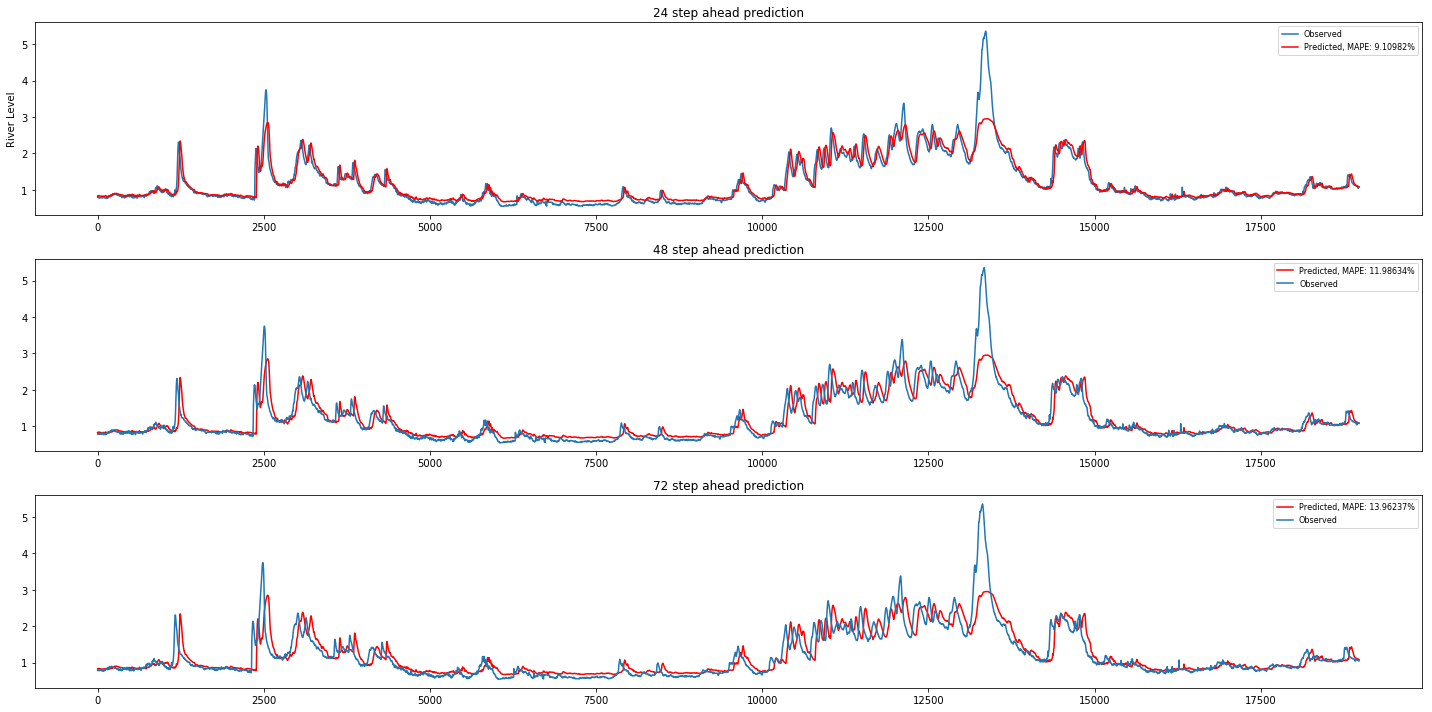

In [9]:
plot_errors(pred_test, test_y, errors)

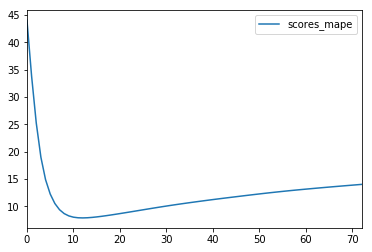

In [11]:
pd.DataFrame(scores, index=["scores_mape"]).T.plot()

In [15]:
pd.DataFrame(history.history)

,val_loss,loss
0,0.283278,0.327532


In [56]:
pd.DataFrame(scores, index=["scores_mape"]).T.plot()

TypeError: Empty 'DataFrame': no numeric data to plot

In [57]:
pd.DataFrame(history[0].history).plot()

TypeError: 'History' object does not support indexing

In [1]:
from keras.utils import plot_model
plot_model(model)

Using TensorFlow backend.


NameError: name 'model' is not defined

In [10]:
import sys

In [11]:
!{sys.executable} -m pip install pydot